## Approximate State Preparation using MPS Sequential Encoding

Author: Amir Ali Malekani Nezhad (Qualition)

State Preparation is the task of compiling a quantum statevector $\ket{\psi}$ to a quantum circuit. There have been many approaches proposed by Shende, Mottonen, Perciano, Ran, Rudolph, et al who have proposed different schema for tackling this problem. Additionally, some like Pollmann et al have focused on specific types of states which made their algorithm a better fit compared to current state-of-the-art.

This topic has been researched since the early 2000s, and the summary of which is presented below:
- **Exact encoding of arbitrary statevectors:** Amplitude encoding was proposed as the most efficient exact encoding approach to compile arbitrary statevectors. These approaches primarily developed by Shende [[1]] and Mottonen [[2]] and Iten et al [[3]] focus on encoding a vector of $2^N$ elements over a quantum circuit with $N$ qubits and a depth of $2^N$ approximately. Such an approach as inferred from quantum information theory proved that we require an exponential number of gates to encode such an exponential data structure. Whilst these approaches are actively used in most modern packages they still bottleneck the implementation of practical quantum algorithms using this subroutine on actual hardware.
- **Variational encoding of arbitrary statevectors:** With the issue present in Amplitude Encoding, during the 2015 to early 2020s many researchers pivoted towards using QML to approximately encode statevectors. This approach differed significantly from that of Amplitude encoding as it was stochastic (no analytical decomposition like Amplitude encoding), and focused on an iterative approach to gradually train a QNN to fit to the target state's distribution [[4]]. These approaches also had their own challenges, i.e., "orthogonality catastrophe". Orthogonality catastrophe in quantum machine learning refers to a situation where a small change in the parameters of a quantum model causes the quantum state to change drastically, becoming almost completely different (orthogonal) from the original state. This causes an exponential decay in the fidelity measure as the size of the system (number of qubits) increases. This caused more focus on the expressivity of the ansatzes proposed, and the training approach to avoid Barren Plateaus.
- **MPS encoding:** First seen in 2008 [[5]] and becoming prominently known with Ran's work in 2019 [[6]], MPS became a massive success in approximate compilation of statevectors. The approach utilized MPS representation of dense tensors (aka the statevector) to reduce the number of parameters needed to represent the tensor from $2^N$ to $2N\chi^2$ where $\chi$ is called the bond dimension and serves as a hyperparameter controlling the fidelity of the encoding. Given a constant and modest bond dimension as we increase $N$, we in fact reduce the scaling from $O(2^N)$ to $O(N)$. This allowed the limitation imposed by exact encoding to be relaxed to $O(N)$ and provided a significant reduction in depth. However, even MPS approach yet again had challenges. MPS tackles entanglement in a 1D manner, meaning long-range entanglement (if q0 and qN are entangled, this is long-range, whereas q0 and q1 entangled would be considered short-range) had to be captured via deeper circuits. Additionally, Ran's approach required many layers to adequately encode certain types of states, and is known for being very slow to converge. To tackle this, Rudolph et al [[7]] published a work in 2022 which utilized Environment Tensor Updates to optimize the circuit produced by Ran and find the optimal parameters for the circuit without changing depth. This solved the issue with Ran, and is considered state-of-the-art as of writing this notebook.

We can see there have been many different approaches to tackle this problem, each solving some problems and introducing new ones, and in pursuing perfection we have come a long long way from early 2000s works.

[1]: https://arxiv.org/abs/quant-ph/0406176
[2]: https://arxiv.org/abs/quant-ph/0407010
[3]: https://arxiv.org/abs/1501.06911
[4]: https://arxiv.org/abs/1612.02806
[5]: https://arxiv.org/abs/2008.10322
[6]: https://arxiv.org/abs/1908.07958
[7]: https://arxiv.org/abs/2209.00595

### Ran's approach

In simple terms, Ran's approach constructs an MPS from the statevector we want to compile. To exactly encode the MPS we don't need more than one layer, however, we would need $\lceil log_2(\chi) \rceil + 1$ qubits for the tensors depending on their bond dimension. This leads to larger circuits and makes it harder to transfer the circuits to hardware.

He proposed to truncate the bond dimension of the MPS to 2, and encode the truncated version to a circuit which would now only require 1 and 2 qubit gates. This approximately encodes the MPS. To improve the fidelity, we need to generate many layers. Below is the pseudocode borrowed from Rudolph et al. Ran generates a layer, applies its inverse to the original MPS to "update" it or more accurately disentangle it (push it closer to product state $\ket{00 \cdots 0}$), and generates a new layer from the updated original MPS. We do so until we run out of layers, or reach close enough to product state.

Thus, an approximate encoding using an iterative disentangling approach.

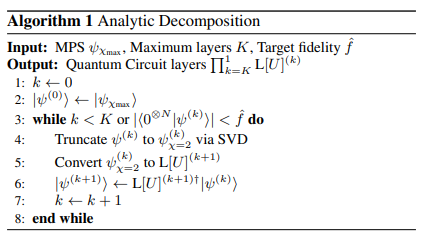

Freeze `numba==0.60.0` to avoid index error.

In [ ]:
!pip install quimb==1.11.2 numba==0.60.0 --break-system-packages -q

In [1]:
import numpy as np
from numpy.typing import NDArray
import quimb.tensor as qtn

import cudaq

/home/ace07/Documents/GitHub/QMPRS/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/home/ace07/Documents/GitHub/QMPRS/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/home/ace07/Documents/GitHub/QMPRS/.venv/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


In [2]:
def gram_schmidt(matrix: NDArray[np.complex128]) -> NDArray[np.complex128]:
    """ Perform Gram-Schmidt orthogonalization on the columns of a matrix
    to define the unitary block to encode the MPS.

    Notes
    -----
    If a column is (approximately) zero, it is replaced with a random vector.

    Parameters
    ----------
    `matrix` : NDArray[np.complex128]
        Input matrix with complex entries.

    Returns
    -------
    `unitary` : NDArray[np.complex128]
        A unitary matrix with orthonormal columns derived from the input matrix.
        If a column is (approximately) zero, it is replaced with a random vector.
    """
    num_rows, num_columns = matrix.shape
    unitary = np.zeros((num_rows, num_columns), dtype=np.complex128)
    orthonormal_basis: list[NDArray[np.complex128]] = []

    for j in range(num_columns):
        column = matrix[:, j]

        # If column is (approximately) zero, replace with random
        if np.allclose(column, 0):
            column = np.random.uniform(-1, 1, num_rows)
            if np.iscomplexobj(matrix):
                column = column + 1j * np.random.uniform(-1, 1, num_rows)

        # Gram-Schmidt orthogonalization
        for basis_vector in orthonormal_basis:
            column -= (basis_vector.conj().T @ column) * basis_vector

        # Handle near-zero vectors (linear dependence)
        norm = np.linalg.norm(column)
        if norm < 1e-12:
            is_complex = np.iscomplexobj(matrix)
            column = np.random.uniform(-1, 1, num_rows)
            if is_complex:
                column += 1j * np.random.uniform(-1, 1, num_rows)
            for basis_vector in orthonormal_basis:
                column -= (basis_vector.conj().T @ column) * basis_vector

        unitary[:, j] = column / np.linalg.norm(column)
        orthonormal_basis.append(unitary[:, j])

    return unitary

In [8]:
class Sequential:
    def __init__(self, target_fidelity) -> None:
        """Initialize the Sequential class.

        Args:
            target_fidelity (float): The target fidelity for the MPS encoding.
        """
        self.target_fidelity = target_fidelity

    def generate_layer(self, mps: qtn.MatrixProductState) -> list[tuple[list[int], NDArray[np.complex128]]]:
        """ Convert a Matrix Product State (MPS) to a circuit representation
        using a single unitary layer.

        Args:
            mps (qtn.MatrixProductState): The MPS to convert.

        Returns:
            unitary_layer (list[tuple[list[int], NDArray[np.complex128]]]): A list of
            tuples representing the unitary layer of the circuit.
                Each tuple contains:
                - A list of qubit indices (in LSB order) that the unitary acts on.
                - A unitary matrix (as a 2D NumPy array) that encodes the MPS.
        """
        num_sites = mps.L

        unitary_layer: list[tuple[list[int], NDArray[np.complex128]]] = []

        for i, tensor in enumerate(reversed(mps.arrays)):
            i = num_sites - i - 1

            # MPS representation uses 1D entanglement, thus we need to define
            # the range of the indices via the tensor shape
            # i.e., if q0 and q3 are entangled, then regardless of q1 and q2 being
            # entangled the entanglement range would be q0-q3
            if i == 0:
                d_right, d = tensor.shape
                tensor = tensor.reshape((1, d_right, d))
            if i == num_sites - 1:
                d_left, d = tensor.shape
                tensor = tensor.reshape((d_left, 1, d))

            tensor = np.swapaxes(tensor, 1, 2)

            # Combine the physical index and right-virtual index of the tensor to construct an isometry
            # matrix
            d_left, d, d_right = tensor.shape
            isometry = tensor.reshape((d * d_left, d_right))

            # Put qubit ordering in LSB (we provide this so that users can modify between LSB and MSB)
            # To put into MSB, comment the second line below
            qubits = reversed(range(i - int(np.ceil(np.log2(d_left))), i + 1))
            qubits = [abs(qubit - num_sites + 1) for qubit in qubits] # type: ignore

            # Create all-zero matrix and add the isometry columns
            matrix = np.zeros((isometry.shape[0], isometry.shape[0]), dtype=isometry.dtype)

            # Keep columns for which all ancillas are in the zero state
            matrix[:, : isometry.shape[1]] = isometry

            # Perform Gram-Schmidt orthogonalization to ensure the columns are orthonormal
            unitary = gram_schmidt(matrix)

            # Store the unitary layer for the circuit
            unitary_layer.append((qubits, unitary)) # type: ignore

        return unitary_layer

    def mps_to_circuit_approx(
            self,
            statevector: NDArray[np.complex128],
            max_num_layers: int,
            chi_max: int
        ) -> cudaq.Kernel:
        r""" Approximately encodes the MPS into a circuit via multiple layers
        of exact encoding of bond 2 truncated MPS.

        Notes
        -----
        Whilst we can encode the MPS exactly in a single layer, we require
        $log(chi) + 1$ qubits for each tensor, which results in larger circuits.
        This function uses bond 2 which allows us to encode the MPS using one and
        two qubit gates, which results in smaller circuits, and easier to run on
        hardware.

        This is the core idea of Ran's paper [1].

        [1] https://arxiv.org/abs/1908.07958

        Parameters
        ----------
        `statevector` : NDArray[np.complex128]
            The statevector to convert, which should be normalized.
        `max_num_layers` : int
            The maximum number of layers to use in the circuit.
        `chi_max` : int
            The maximum bond dimension for the MPS compression.

        Returns
        -------
        `circuit` : cudaq.Kernel
            The CUDA Quantum circuit that approximates the statevector.
        """
        mps = qtn.MatrixProductState.from_dense(statevector)
        mps: qtn.MatrixProductState = qtn.tensor_1d_compress.tensor_network_1d_compress(mps, max_bond=chi_max) # type: ignore
        mps.permute_arrays()

        mps.compress(form="left", max_bond=chi_max)
        mps.left_canonicalize(normalize=True)

        compressed_mps = mps.copy(deep=True)
        disentangled_mps = mps.copy(deep=True)

        circuit = cudaq.make_kernel()
        qr = circuit.qalloc(mps.L)

        unitary_layers = []

        # Initialize the zero state |00...0> to serve as comparison
        # for the disentangled MPS
        zero_state = np.zeros((2**mps.L,), dtype=np.complex128)
        zero_state[0] = 1.0  # |00...0> state

        # Ran's approach uses a iterative disentanglement of the MPS
        # where each layer compresses the MPS to a maximum bond dimension of 2
        # and applies the inverse of the layer to disentangle the MPS
        # After a few layers we are adequately close to |00...0> state
        # after which we can simply reverse the layers (no inverse) and apply them
        # to the |00...0> state to obtain the MPS state
        for layer_index in range(max_num_layers):
            # Compress the MPS from the previous layer to a maximum bond dimension of 2,
            # |ψ_k> -> |ψ'_k>
            compressed_mps = disentangled_mps.copy(deep=True)

            # Normalize improves fidelity of the encoding
            compressed_mps.normalize()
            compressed_mps.compress(form="left", max_bond=2)

            # Generate unitary layer
            unitary_layer = self.generate_layer(compressed_mps)
            unitary_layers.append(unitary_layer)

            # To update the MPS definition, apply the inverse of U_k to disentangle |ψ_k>,
            # |ψ_(k+1)> = inv(U_k) @ |ψ_k>
            for i, _ in enumerate(unitary_layer):
                inverse = unitary_layer[-(i + 1)][1].conj().T

                if inverse.shape[0] == 4:
                    disentangled_mps.gate_split_(
                        inverse, (i - 1, i)
                    )
                else:
                    disentangled_mps.gate_(
                        inverse, (i), contract=True
                    )

            # Compress the disentangled MPS to a maximum bond dimension of chi_max
            # This is to ensure that the disentangled MPS does not grow too large
            # and improves the fidelity of the encoding
            disentangled_mps: qtn.MatrixProductState = qtn.tensor_1d_compress.tensor_network_1d_compress( # type: ignore
                disentangled_mps, max_bond=chi_max
            )

            fidelity = np.vdot(disentangled_mps.to_dense(), zero_state)

            if fidelity >= self.target_fidelity:
                # If the disentangled MPS is close enough to the zero state,
                # we can stop the disentanglement process
                print(f"Reached target fidelity in {layer_index + 1} layers.")
                break

        if layer_index == max_num_layers - 1:
            print(f"Reached {fidelity} with the maximum number of layers {max_num_layers}.")

        # The layers disentangle the MPS to a state close to |00...0>
        # inv(U_k) ... inv(U_1) |ψ> = |00...0>
        # So, we have to reverse the layers and apply them to the |00...0> state
        # to obtain the MPS state
        # |ψ> = U_1 ... U_k |00...0>
        unitary_layers.reverse()

        # Apply the unitary layers to the |00...0> state
        gate_index = 0
        for unitary_layer in unitary_layers:
            for qubits, unitary in unitary_layer:
                gate_name = f"unitary_{gate_index}"
                cudaq.register_operation(gate_name, unitary)
                qubits = [qr[qubit_index] for qubit_index in qubits]
                qubits.reverse()
                circuit.__getattr__(gate_name)(*qubits)
                gate_index += 1

        return circuit

    def __call__(
            self,
            statevector: NDArray[np.complex128],
            max_num_layers: int,
            chi_max: int
        ) -> cudaq.Kernel:
        """ Call the instance to generate a circuit from the MPS.

        Parameters
        ----------
        `statevector` : NDArray[np.complex128]
            The statevector to convert.
        `max_num_layers` : int
            The maximum number of layers to use in the circuit.
        `chi_max` : int
            The maximum bond dimension for the MPS compression.

        Returns:
            cudaq.Kernel: The generated quantum circuit.
        """
        return self.mps_to_circuit_approx(statevector, max_num_layers, chi_max)

In [10]:
np.random.seed(1)

def generate_random_state(num_qubits: int) -> NDArray[np.complex128]:
    """ Generate a random normalized quantum state vector.

    Parameters
    ----------
    `num_qubits` : int
        The number of qubits in the state.

    Returns
    -------
    `statevector` : NDArray[np.complex128]
        A normalized state vector of shape (2**num_qubits,).
    """
    statevector = np.random.rand(2**num_qubits) + 1j * np.random.rand(2**num_qubits)
    return statevector / np.linalg.norm(statevector)

In [ ]:
statevector = generate_random_state(4)

encoder = Sequential(target_fidelity=0.99)
qc = encoder(statevector, max_num_layers=3, chi_max=2**9)

# Sanity check
print(np.dot(
    np.array(cudaq.StateMemoryView(cudaq.get_state(qc))).conj().T, statevector
))

Reached target fidelity in 1 layers.
(0.9930301077191865+2.657153153062808e-08j)


In [ ]:
statevector = generate_random_state(6)

encoder = Sequential(target_fidelity=0.99)
qc = encoder(statevector, max_num_layers=3, chi_max=2**9)

# Sanity check
print(np.dot(
    np.array(cudaq.StateMemoryView(cudaq.get_state(qc))).conj().T, statevector
))

Reached (0.9566448180001509-6.505556919443983e-18j) with the maximum number of layers 3.
(0.956644869705398-2.680174415736758e-09j)
